In [1]:
import mitsuba as mi
import drjit as dr 
mi.set_variant("cuda_ad_rgb")

# Generates a surface shape using a normal distribution

In [2]:
M = 100
N = 100

x, y = dr.meshgrid(
    dr.linspace(mi.Float, -36,   36, M),
    dr.linspace(mi.Float, -36,   36, N)
)

mu = [10, 10]
sigma = [8,8]


z1 = dr.exp(-dr.power((x-mu[0])/sigma[0],2)/2)/sigma[0]
z2 = dr.exp(-dr.power((y-mu[1])/sigma[1],2)/2)/sigma[1]

z = -z1*z2/dr.two_pi*1000


In [10]:
from utils.meshbuilder import grid_mesh_build

mesh = grid_mesh_build([-36,-36],[36,36],[M,N],z)

mesh.write_ply("../scenes/meshes/face.ply")

Mesh[
  name = "surface",
  bbox = BoundingBox3f[
    min = [-36, -36, -2.48551],
    max = [36, 36, -1.08838e-14]
  ],
  vertex_count = 10000,
  vertices = [117 KiB of vertex data],
  face_count = 19602,
  faces = [230 KiB of face data],
  face_normals = 0
]

# Visualize mesh file

In [4]:
mesh = mi.load_dict({
    "type": "ply",
    "filename": "../scenes/meshes/face.ply",
    "bsdf": {
        "type": "diffuse",
        "reflectance": {
            "type": "mesh_attribute",
            "name": "vertex_color",  # This will be used to visualize our attribute
        },
    },
})

# Needs to start with vertex_ or face_
attribute_size = mesh.vertex_count() * 3
mesh.add_attribute(
    "vertex_color", 3, [0] * attribute_size
)  # Add 3 floats per vertex (initialized at 0)

In [5]:
mesh_params = mi.traverse(mesh)
M = 100
N = 100

vertex_colors = dr.zeros(mi.Float, 3 * N*M)
idx,idy =  dr.meshgrid(
    dr.arange(mi.UInt32, M),
    dr.arange(mi.UInt32, N)
)


fringe_vertex_indices = idx+idy*M

vertex_z = dr.gather(mi.Float, mesh_params["vertex_positions"], fringe_vertex_indices*3 + 2),
max_z = dr.max(vertex_z[0])
min_z = dr.min(vertex_z[0])


color = (vertex_z[0]-min_z)/(max_z-min_z)

dr.scatter(vertex_colors, color/2, fringe_vertex_indices * 3)  # Fringe is red

mesh_params["vertex_color"] = vertex_colors
mesh_params.update()


[(PLYMesh[
    name = "face.ply",
    bbox = BoundingBox3f[
      min = [-36, -36, -2.48551],
      max = [36, 36, -1.08838e-14]
    ],
    vertex_count = 10000,
    vertices = [352 KiB of vertex data],
    face_count = 19602,
    faces = [230 KiB of face data],
    face_normals = 0,
    mesh attributes = [
      vertex_color: 3 floats
    ]
  ],
  {'vertex_color'})]

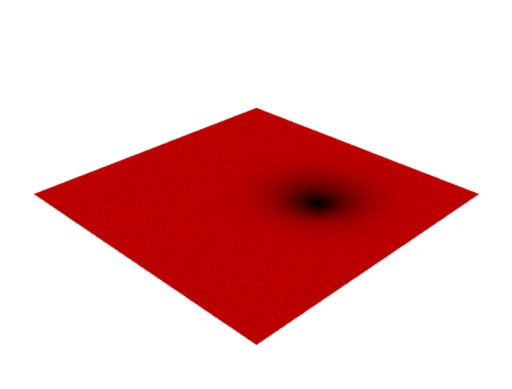

In [6]:
scene = mi.load_dict({
    "type": "scene",
    "integrator": {"type": "path"},
    "light": {"type": "constant"},
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=[100, -100, 80], target=[0, 0, 0], up=[0, 0, 1]
        ),
    },
    "facedisk": mesh,
})

img = mi.render(scene)

from matplotlib import pyplot as plt

plt.axis("off")
plt.imshow(mi.util.convert_to_bitmap(img));


In [7]:
min_z

[-2.4855117797851562]